#### This notebook, as the name suggests, is just for fun. It holds any interesting findings or any "aha" moments.

<b>1.</b> In the cells below you will see that the number of non-zeros in the matrix read from .mtx file is much larger than the number of lines (hence the number of edges) in the graph. What gives? 

Hint: See the ratio of count of non-zeros and number of edges! 

In [9]:
from scipy import io
import numpy as np

mtx_path = '..\data\socfb-American75.mtx'
mat = io.mmread(mtx_path)

print("number of vertices:", mat.shape[0])
print("percentage of non-zero elements in the matrix:", np.round(mat.count_nonzero()/np.prod(mat.shape)*100, 2))

number of vertices: 6386
percentage of non-zero elements in the matrix: 1.07


In [8]:
with open('../data/socfb-American75.edgelist') as file:
    lines = file.readlines()

print("number of edges in edgelist file =", len(lines), ", number of non-zero entries in matrix =", mat.count_nonzero())
print("Ratio of non-zero entries to number of edges =", mat.count_nonzero()/len(lines))

number of edges in edgelist file = 217662 , number of non-zero entries in matrix = 435324
Ratio of non-zero entries to number of edges = 2.0


#### Reason: The .mtx file with symmetric format stores only the entries on or below the main diagonal. So if you have an edge from node 1 to node 100, there would be entries at (1, 100) and (100, 1) in the matrix but only one edge in the mtx file to save space.

<b>2.</b> Let's analyse the data now. For that I will use the processed data which I saved in 'data_prep.ipynb' to avoid writing all the here again.

In [4]:
from tqdm.auto import tqdm
import pickle
import sys
import numpy as np

# read embeddings
emd_path = '../data/emb/socfb-American75.emd'
emd_map = {}
with open(emd_path, 'r') as file:
    lines = file.readlines()
    for line in lines[1:]:
        temp = line.split(' ')
        emd_map[np.int(temp[0])] = np.array(temp[1:], dtype=np.float)

# read the distances from landmarks
save_path = '../outputs/distance_map_1588792161.8904061.pickle'
distance_map = pickle.load(open(save_path, 'rb'))

# for the training data: avg(emd_node1, emd_node2) -> distance
emd_dist_pair = []
for landmark in tqdm(list(distance_map.keys())):
    node_distances = distance_map[landmark]
    emd_dist_pair.extend([((emd_map[node]+emd_map[landmark])/2, distance) for node, distance in enumerate(node_distances, 1) if node != landmark and distance != np.inf])

print('length of embedding-distance pairs', len(emd_dist_pair))

# for numpy ndarray 
x = np.zeros((len(emd_dist_pair), len(emd_dist_pair[0][0])))
y = np.zeros((len(emd_dist_pair),))

for i, tup in enumerate(tqdm(emd_dist_pair)):
    x[i] = tup[0]
    y[i] = tup[1]
print("Shape of x={} and y={}".format(x.shape, y.shape))

100%|██████████| 955350/955350 [00:01<00:00, 629347.28it/s]Shape of x=(955350, 128) and y=(955350,)
size of x=932.9590911865234 MB and y=7.2888336181640625 MB



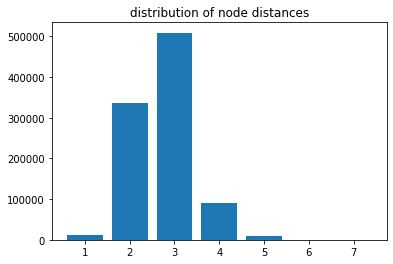

In [8]:
from matplotlib import pyplot as plt

values, counts = np.unique(y, return_counts=True)
plt.bar(values, counts, align='center')
plt.title('distribution of node distances')
plt.show()

So most of nods have distance of 2 or 3 among them. This makes prediction hard, since model learns to predict 2.x values to be safe. Problem seems to be harder than I imagined.